In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors.regression import KNeighborsRegressor
from sklearn.cross_validation import PredefinedSplit
from sklearn.grid_search import GridSearchCV

## Forecasting with machine learning models

Recently I worked on a project where I had to compute long-term forecasts for a large number (around 500K) of time series. Coming from a statistics background I was familiar with some of the standard methods in the literature, like seasonal [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) models and [state-space models](https://en.wikipedia.org/wiki/State-space_representation).

For me, there were two main obstacles that prevented me from using these models:

1. I needed **longer-term** forecasts for each time series: ARIMA models are typically well-suited for short-term forecasts, but not for longer term forecasts due to the autoregressive part of the model.
2. I had to provide forecasts for a very **large number** of time series: Hence, I needed a computationally cheap type of model. This ruled out using some of the Bayesian models because the MCMC algorithms can be quite expensive.

Instead I opted for a more algorithmic point of view and decided to try out some machine learning methods. Most of these methods are designed for independent and identically distributed (IID) data however, so it is interesting to see how we can apply these models to non-IID data (e.g. time series data).

### Forecasting strategies

Throughout this post we will make the following *non-linear autoregressive representation* (NAR) assumption. Let $y_t$ denote the value of the time series at time point $t$, then we assume that

$$ y_t = f(y_{t - 1}, \ldots, y_{t - n})+ \epsilon_t, $$

for some autoregressive order $n$ and where $\epsilon_t$ represents some noise at time $t$ and $f$ is an arbitrary and unknown function. The goal is to learn this function $f$ from the data and obtain forecasts for $t + h$, where $h \in \{1, \ldots, H\}$. Hence we are interested in predicting the next $H$ data points, not just the $H$-th data point, given the history of the time series.

When $H = 1$ (*one-step ahead forecasting*), it is straightforward to apply most machine learning methods on your data. In the case where we want to predict multiple time periods ahead ($H > 1$) things become a little more interesting.

In this case there are three common ways of forecasting:

* Iterated one-step ahead forecasting.
* Direct $H$-step ahead forecasting.
* Multiple input multiple output models.

### Iterated forecasting

In iterated forecasting, we optimize a model based on a one-step ahead criterion and when calculating a $H$-step ahead forecast, we iteratively feed the forecasts of the model back in as input for the next prediction. In Python, a function that would compute the iterated forecast could look like this:

In [2]:
def generate_features(x, forecast, window):
    """ Concatenates a time series vector x with forecasts from
        the iterated forecasting strategy.

    Arguments:
    ----------
        x:        Numpy array of length T containing the time series.
        forecast: Scalar containing forecast for time T + 1.
        window:   Autoregressive order of the time series model.
    """
    augmented_time_series = np.hstack((x, forecast))

    return augmented_time_series[-window:].reshape(1, -1)

def iterative_forecast(model, x, window, H):
    """ Implements iterative forecasting strategy

    Arguments:
    ----------
        model: scikit-learn model that implements a predict() method
               and is trained on some data x.
        x:     Numpy array containing the time series.
        h:     number of time periods needed for the h-step ahead forecast
    """
    forecast = np.zeros(H)    
    forecast[0] = model.predict(x.reshape(1, -1))

    for h in range(1, H):
        features = generate_features(x, forecast[:h], window)

        forecast[h] = model.predict(features)

    return forecast

To understand the disadvantage of this method a bit better, it helps to go back to the original goal of our problem. What we are really trying to do is to approximate $\mathbb{P}\left[ Y \| X \right]$ where $Y \in \mathbb{R}^H$ and $X \in \mathbb{R}^n$. We can visualize this distribution by using a graphical model. In the case $n = 2$ the distribution of the time series data can be represented as follows

![jpg](ts-graphical-model.jpg)

Now, the distribution of our approximation is actually a bit different and looks more like this:

![jpg](ts-iterated-prediction.jpg)

The iterated strategy returns an unbiased estimator of $\mathbb{P}\left[Y \| X\right]$ since it preserves the stochastic dependencies of the underlying data. In terms of the bias-variance trade-off however, it suffers from high variance due to the accumulation of error in the individual forecasts. This means we will get a low performance over longer time horizons $H$.

### $H$-step ahead forecasting

In direct $H$-step ahead forecasting, we learn $H$ different models of the form

$$ y_{t + h} = f_h (y_t, \ldots, y_{t - n}) + \epsilon_{t + h}, $$

where $h \in \{1, \dots, H\}$, $n$ is the number of past data points and $f_h$ is any arbitrary learner. Training the models $f_h$ in Python is relatively straightforward, you only need to use different (lagged) versions of your training data $X$ and response $y$.

In [3]:
def ts_to_training(x, window, h):
    """ Generates a training and test set from a time series
        assuming we want to calculate a h-step ahead forecast.

    Arguments:
    ----------
        x: Numpy array that contains the time series.
        h: Number of periods to forecast into the future.
    """
    n = x.shape[0]
    nobs = n - h - window + 1

    features = np.zeros((nobs, window))
    response = np.zeros((nobs, 1))

    for t in range(nobs):
        features[t, :] = x[t:(t + window)]
        response[t, :] = x[t + window]

    return features, response


def direct_forecast(model, x, window, H):
    """ Implements direct forecasting strategy

    Arguments:
    ----------
        model: scikit-learn model that implements fit(X, y) and
               predict(X)
        x:     history of the time series
        H:     number of time periods needed for the H-step ahead forecast
    """
    forecast = np.zeros(H)

    for h in range(1, H + 1):
        X, y = ts_to_training(x, window=window, h=h)

        fitted_model = model.fit(X, y)

        forecast[h - 1] = fitted_model.predict(X[-1, :].reshape(1, -1))

    return forecast

We can again visualize the distribution this strategy approximates in a graphical model:

![jpg](ts-direct-prediction.jpg)

Here we see that this approach does not suffer from the accumulation of error, since each model $f_h$ is tailored to predict horizon $h$. However, since the models are trained independently no statistical dependencies between the predicted values $y_{t + h}$ are guaranteed.

An alternative strategy, called the DirRec strategy[^1], can be used to mitigate this assumption. The idea is to still train $H$ different models, but as we predict further into the future we use the forecasts of the earlier periods more and more. Even though this deals with the conditional independence assumption, the strategy is computationally heavy because we now need to train $H$ independent models.

### Multiple input multiple output models

Finally, we can also train one model that takes multiple inputs and returns multiple outputs:

$$ [y_{t + H}, \ldots, y_{t  +1}] = f(y_t, \ldots, y_{t - n}) + \mathbf{\epsilon}. $$

The forecasts are provided in one step, and any learner $f$ that can deal with a multi-dimensional response can be used. This means that you only have to take care when you construct your feature and response data sets. In Python, this could look like this.

In [4]:
def ts_to_mimo(x, window, h):
    """ Transforms time series to a format that is suitable for
        multi-input multi-output regression models.

    Arguments:
    ----------
        x:      Numpy array that contains the time series.
        window: Number of observations of the time series that
                will form one sample for the multi-input multi-output
                model.
        h:      Number of periods to forecast into the future.
    """
    n = x.shape[0]
    nobs = n - h - window + 1

    features = np.zeros((nobs, window))
    response = np.zeros((nobs, h))

    for t in range(nobs):
        features[t, :] = x[t:(t + window)]
        response[t, :] = x[(t + window):(t + window + h)]

    return features, response

The results of the above function can then be piped into any model that takes multi-dimensional input and output data. In long term prediction scenarios, the recursive and direct strategies neglect stochastic dependencies between future values. Using models that take multi-dimensional inputs and outputs therefore seems the most natural choice of models as the main advantages of the MIMO forecasting strategy are that

1. Only one model is trained instead of $H$ different models.
2. No conditional independence assumptions are made (c.f. direct strategy).
3. There is no accumulation of error of individual forecasts (c.f. iterated strategy).

One constraint of the MIMO strategy is that all horizons $H$ are to be forecasted with the same model, which limits the flexibility of our model. One approach to combat this assumption is to combine the direct and MIMO strategy, called the DIRMO strategy[^2]. The general idea is to split the forecasting horizon $H$ into $n = \frac{H}{b}$ blocks of length $b$ (where $b \in \{1, \ldots, H\}$). We then train $n$ different models, where each model is used to predict one of the blocks in a MIMO fashion.

### Using $k$-nearest neighbours to predict monthly car sales

To illustrate the methods discussed above we'll go through a quick example where whe use a $k$-nearest neighbour model as the learner. We'll use a data set of monthly car sales in Quebec starting from January 1960 to December 1968 which I obtained from [DataMarket](https://datamarket.com/data/set/22n4/monthly-car-sales-in-quebec-1960-1968#!ds=22n4&display=line).

First we'll define some helper functions and import the necessary packages.

In [5]:
def create_cv_split(X, perc=0.75):
    n = X.shape[0]
    n_train = np.floor(perc * n).astype(int)
    split = np.ones(n)
    split[:n_train] = -1

    return PredefinedSplit(split)

def plot_predictions(y_history, y_hat, y_true, plot_obs=False):
    history_idx = range(y_history.shape[0])
    pred_idx = range(y_history.shape[0], y_history.shape[0] + y_hat.shape[0])

    plt.figure()
    plt.plot(history_idx, y_history, hold=True, label="Observed")
    plt.plot(pred_idx, y_hat, hold=True, label="Forecast")

    if plot_obs:
        plt.plot(pred_idx, y_true, hold = True, label = "Observed")

    plt.title("Observed versus forecasted observations")
    plt.legend(loc = "best")
    plt.grid(True)
    plt.show()
    
def mse(x_true, x_pred):
    return np.mean(np.sum(np.power(x_true - x_pred, 2)))

def mape(x_true, x_pred):
    return np.mean(np.abs([x / y - 1 for x, y in zip(x_pred, x_true)]))

The time series looks like it has a relatively well behaved seasonal pattern and an upwards trend.

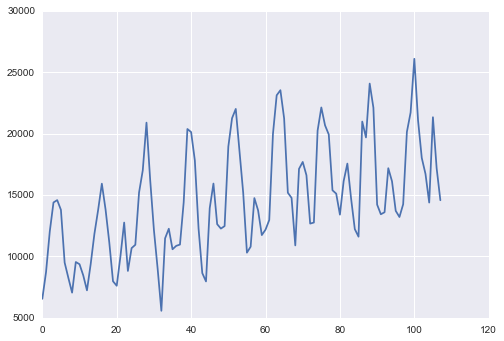

In [6]:
ts = np.genfromtxt("monthly-car-sales-in-quebec-1960.csv", delimiter=",")[1:, 1:].reshape(-1)

plt.plot(ts)

## MIMO forecast

In [7]:
# Multi-input multi-output model
# Set up some global parameters and the model
c = 80
H = 20
window = 20

model = KNeighborsRegressor(algorithm="auto")
param_grid = {"n_neighbors": [2 ** x for x in range(5)],
                  "weights": ["uniform", "distance"],
                  "metric": ["euclidean", "manhattan"]}

X, y = ts_to_mimo(x=ts[:c], window=window, h=H)

cv_split = create_cv_split(X, perc=0.75)
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring="mean_squared_error",
                           cv=cv_split,
                           verbose=True,
                           refit=True)

grid_search.fit(X, y)

grid_search.best_params_

Fitting 1 folds for each of 20 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}

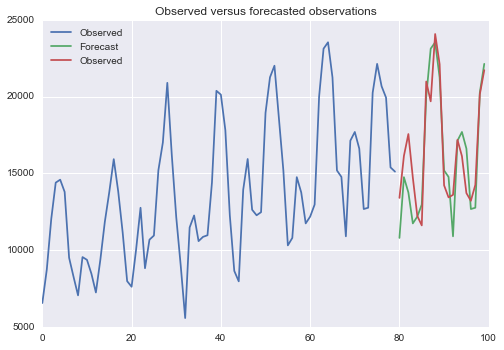

In [8]:
# Now forecast the test period
X_test = ts[(c - window):c].reshape(1, -1)
y_test = ts[c:(c + H)]

y_hat = grid_search.predict(X_test).reshape(-1)

plot_predictions(ts[:c], y_hat, y_test, plot_obs=True)

In [9]:
mape(y_test, y_hat)

0.097596188874814555

## Iterative forecast

Fitting 1 folds for each of 20 candidates, totalling 20 fits
{'weights': 'uniform', 'metric': 'euclidean', 'n_neighbors': 4}


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


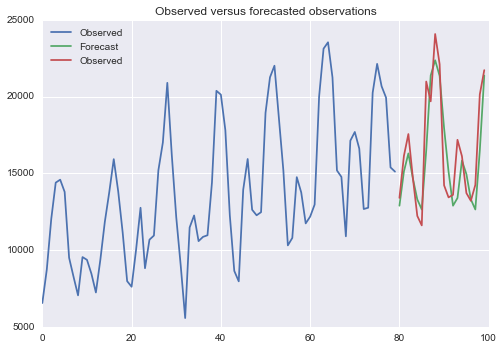

In [10]:
c = 80
H = 20
window = 20

model = KNeighborsRegressor(algorithm="auto")
param_grid = {"n_neighbors": [2 ** x for x in range(5)],
                  "weights": ["uniform", "distance"],
                  "metric": ["euclidean", "manhattan"]}

X, y = ts_to_training(x=ts[:c], window=window, h=1)

cv_split = create_cv_split(X, perc=0.75)
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring="mean_squared_error",
                           cv=cv_split,
                           verbose=True,
                           refit=True)

grid_search.fit(X, y)

print(grid_search.best_params_)

# Now forecast the test period
X_test = ts[(c - window):c]
y_test = ts[c:(c + H)]
y_hat = iterative_forecast(grid_search, X_test, window, H)

plot_predictions(ts[:c], y_hat, y_test, plot_obs=True)

In [11]:
mape(y_test, y_hat)

0.092121352330131218

## Direct forecast

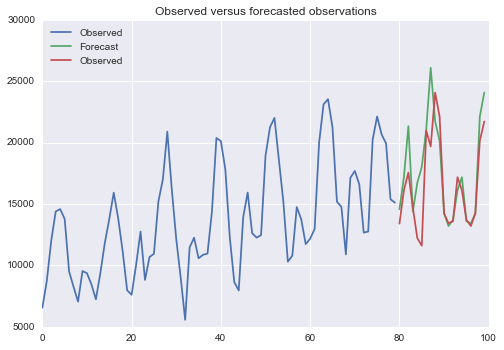

In [12]:
# We use the same model from the iterated strategy
# Now forecast the test period
X_test = ts[(c - window):c]
y_test = ts[c:(c + H)]

model_params = {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}
model = KNeighborsRegressor(**model_params)
y_hat = direct_forecast(model, ts, window, H)

plot_predictions(ts[:c], y_hat, y_test, plot_obs=True)

In [13]:
mape(y_test, y_hat)

0.11090288180625385

Thus, we see that the MIMO and iterative strategy have approximately the same accuracy on the hold out set, whereas the direct forecast performs the worst. 

## Final words

Out of the three strategies discussed here the MIMO strategy seems to be the most natural approach to applying machine learning methods to forecasting problems.

However, when it comes to forecasting there is no silver bullet and what works best may be problem specific. One downside of using machine learning methods (or any non-parametric model for that matter) for forecasting problems is that we can't quantify the uncertainty in our predictions in terms of frequentist confidence or Bayesian credible intervals. This problem can perhaps be partly mitigated by using the [block bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Block_bootstrap) to get bootstrapped confidence intervals.

If your ultimate goal is more explanatory in nature rather than predictive, you may find that more classical models like state-space models will give you better bang for your buck. Bayesian dynamic linear models (DLMs) in particular work nicely here because of their flexibility and ease of interpretation (check out [this](http://multithreaded.stitchfix.com/blog/2016/04/21/forget-arima/) post over at Stitch Fix for an excellent discussion of these models).